In [8]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from benfordslaw import benfordslaw
bl = benfordslaw(verbose=0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import requests

# Data downloaded as XLS from https://results.enr.clarityelections.com/PA/Allegheny/106267/web.264614/#/detail/0004
# worksheet 1 saved to csv to pa_allegheny_county.csv

data = pd.read_csv('data/pa_allegheny_county.csv', skiprows=1)

In [3]:
data.head(3)

,Unnamed: 0,Unnamed: 1,DEM Joseph R. Biden/Kamala D. Harris,Unnamed: 3,Unnamed: 4,REP Donald J. Trump/Mike R. Pence,Unnamed: 6,Unnamed: 7,LIB Jo Jorgensen/Jeremy Spike Cohen,Unnamed: 9,Unnamed: 10,Write-in,Unnamed: 12,Unnamed: 13,Unnamed: 14
0,County,Registered Voters,Election Day,Absentee,Total Votes,Election Day,Absentee,Total Votes,Election Day,Absentee,Total Votes,Election Day,Absentee,Total Votes,Total
1,ALEPPO,1388,166,351,517,347,152,499,6,3,9,2,2,4,1029
2,ASPINWALL DIST 1,861,209,253,462,184,27,211,2,4,6,1,3,4,683


In [4]:
data = pd.read_csv('data/pa_allegheny_county.csv', skiprows=2)
data = data[data.columns[[0, 4, 7, 10]]]

# first column is mislabled (not County)
data.columns = ['Precinct', 'Joe Biden','Donald Trump', 'Jo Jorgensen']

In [5]:
data = data.set_index('Precinct')
data.head(3)

,Joe Biden,Donald Trump,Jo Jorgensen
Precinct,,,
ALEPPO,517,499,9
ASPINWALL DIST 1,462,211,6
ASPINWALL DIST 2,313,126,3


In [6]:
unstacked_data = data.unstack().reset_index().rename(
    columns={0: 'count', 'level_0': 'candidate'})
unstacked_data = unstacked_data[['candidate', 'count', 'Precinct']]
unstacked_data['count'] = unstacked_data['count'].astype(int)
unstacked_data.head(3)

,candidate,count,Precinct
0,Joe Biden,517,ALEPPO
1,Joe Biden,462,ASPINWALL DIST 1
2,Joe Biden,313,ASPINWALL DIST 2


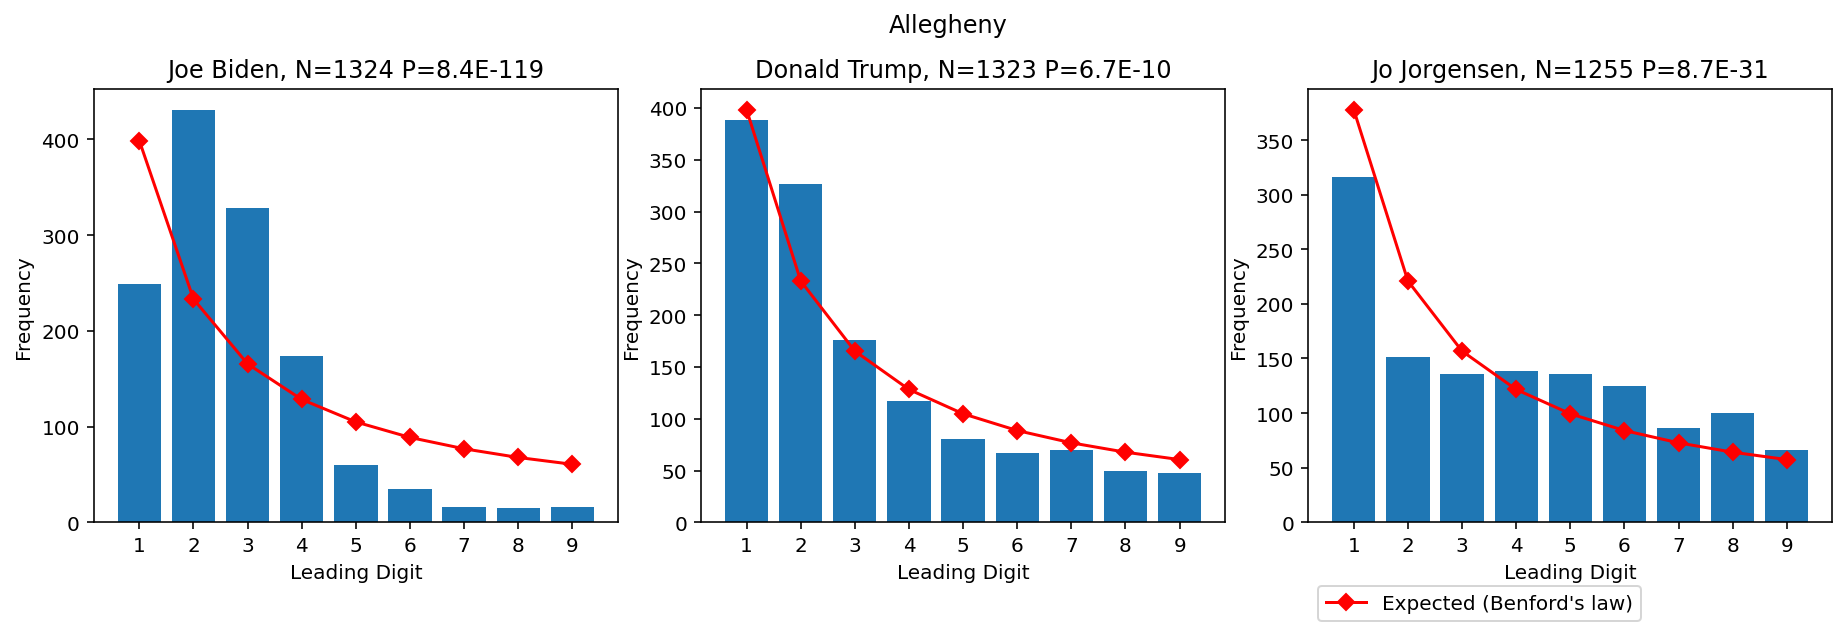

In [9]:

fig, axs = plt.subplots(1, 3, figsize=(16, 4))
fig.tight_layout(rect=[0.1, 0., 0.9, 0.9])

axs = np.array(axs).flatten()
candidates = unstacked_data.candidate.unique()

digit = np.arange(1, 10)

for i in range(len(candidates)):

    ax = axs[i]
    candidate = candidates[i]
    
    N = len(data[data[candidate] > 0])
    
    # expected distribution, from benford's law, normalize by non-zero counts
    expected = np.log10(1 + 1/digit) * N
    
    cur_data = unstacked_data
    cur_data = cur_data.groupby(['candidate', 'Precinct']).sum()
    
    counts = cur_data.loc[candidate]['count']
    P = bl.fit(np.array(counts.astype(int).tolist()))['P']
    
    digits = counts.astype(str).str[0].astype(int)
    digits = digits[digits > 0]
    
    v = digits.value_counts()
    ax.bar(v.index, v.values)
    ax.set_xticks(range(1, 10))
    
    ax.set_title("%s" % (candidate))
    ax.plot(digit, expected, marker='D', color='red', label='Expected (Benford\'s law)')
    
    if P < .001:
        ax.set_title("%s, N=%d P=%.1E" % (candidate, N,P))
    else:
        ax.set_title("%s, N=%d P=%0.3f" % (candidate, N,P))
    
    ax.set_xlabel("Leading Digit")
    ax.set_ylabel("Frequency")

plt.legend(loc=3, bbox_to_anchor=(0.0, -0.25))
plt.suptitle("Allegheny")
plt.savefig('images/allegheny.png')